# Emergence of Order from Disorder: Turing Pattern Formation  in Reaction-Diffusion Models 

*Cem Özen*, December 2017.

In this notebook, I outline the Turing pattern formation in reaction-diffusion systems briefly. Numerical simulations in this notebook show how a change in the stability of steady-state solutions can create spatio-temporal patterns according to Alan Turing's reaction-diffusion theory.

### Pattern formation in the Gray-Scott model

I have created the gif images you see below from  simulations of the Gray-Scott model

$$
\begin{eqnarray}
\frac{\partial u}{\partial t} & = & D_u \vec{\nabla} u - uv^2 + f(1 - u), \\
\frac{\partial v}{\partial t} & = & D_u \vec{\nabla} u + uv^2 - (f + k)v,
\end{eqnarray}
$$

for various values of the system's parameters, that is $D_u$, $D_v$, $f$, and $k$. Here $u$ and $v$ are two diffusable chemicals interacting with each other, and color schemes used in each image characterizes high and low concentration values of the species $u$. (Naturally, one could also obtain the complementary images for the species $v$.) 

Each image is obtained by simulating the model with the shown values of $D_u, D_v, f, k$ values : <br>


<div align="center">$0.0016, 0.0008, 0.035, 0.065$</div> | <div align="center">$0.0016, 0.0008, 0.060, 0.062$</div>  | <div align="center">$0.0019, 0.0005, 0.060, 0.062$</div> | <div align="center">$0.0014, 0.0006, 0.060, 0.062$</div> 
- | - | - | - 
<img src="./animations/gray_scott_bacteria1.gif" width="250"> | <img  src="./animations/gray_scott_worms1.gif" width="250"> | <img src="./animations/gray_scott_fingerprints1.gif" width="250"> | <img src="./animations/gray_scott_worms_bacteria1.gif" width="250">  

### Diffusion-driven Instability

Mathematically, the basis of Turing pattern formation is *diffusion-driven* instability of a steady state. In diffusion-driven instability, the linearly steady state of a dynamical system made of two diffusable, interacting species goes unstable with the inclusion of diffusion; hence the system undergoes a symmetry-breaking transition from a spacially homogenous to a non-homogenous distribution. (Turing, 1952). Turing called the interacting chemical species the *morphogenes*. Below, $u=u(\vec{x}, t)$ and $v=v(\vec{x}, t)$ represent the concentrations of the two diffusable morphogenes, and $D_u$ and $D_v$ label their diffusion coefficients, respectively. Accordingly, the reaction-diffusion system is defined by 

$$
\begin{eqnarray}
\frac{\partial u}{\partial t} & = & f(u, v) + D_u \vec{\nabla} u, \\
\frac{\partial v}{\partial t} & = & g(u, v) + D_v \vec{\nabla} v,
\end{eqnarray}
$$

Above, $f$ and $g$ are nonlinear functions accounting for the chemical process that produce and destroy $u$ and $v$ respectively, while the Laplacian terms account for the diffusion of the species---hence the nomenclature *reaction-diffusion* model.

In the absence of diffusion, that is when $D_u=D_v=0$, the system has stationary states,  $(u_0, v_0)$, which are determined by the simultaneous solution of 

$$
\begin{eqnarray}
 f(u_0, v_0) & = & 0, \\
 g(u_0, v_0) & = & 0.
\end{eqnarray}
$$

The conditions for the *diffusion-induced instability* follow from a linearized stability analysis of the system. In the absence of diffusion, steady-state solutions need to be stable; however, we require that the introduction of diffusion render it unstable. Mathematically, these conditions are:

$$
\begin{eqnarray}
 (1)\quad & \mathrm{tr}(J)   =  f_u + g_v & < & 0  \\
 (2)\quad & \mathrm{det}(J)  =  f_u g_v + f_v g_u & > & 0  \\
 (3)\quad & D_v f_u + D_u g_v & > & 0
\end{eqnarray}
$$

where $J$ is the Jacobian of the system, given by

$$
\begin{eqnarray}
J & = &  \left\vert\matrix{ f_u & f_v  \cr 
                            g_v & g_v
                           }\right\vert_{(u_0, v_0)} 
    = \left\vert\matrix{{\partial f \over \partial u} & {\partial f\over \partial v}  \cr 
                           {\partial g \over \partial u} & {\partial g\over \partial v}
                           }\right\vert_{(u_0, v_0)} 
\end{eqnarray}
$$

### Solving the Coupled Partial Differential Equation System

In [1]:
import numpy as np 
from IPython.display import display, Image, HTML, Math, Latex
import matplotlib.pyplot as plt
from matplotlib import animation, rc
%matplotlib inline

In order to solve these coupled partial differential equations, I will use the simple-to-implement *forward Euler integration* scheme to reduce these systems to finite-difference equations. Accorddigly, the time derivatives are evaluated in the forward difference scheme: 

$$
\begin{eqnarray}
\frac{\partial u}{\partial t} (x, y;t) = \frac{u (x, y;t + \Delta t) - u (x, y;t) }{\Delta t}
\end{eqnarray},
$$

while the Laplacian operator is represented as a central difference formula:

$$
\begin{eqnarray}
\vec{\nabla} u (x, y;t) = \frac{u (x + \Delta x, y;t) + u (x -\Delta x, y;t) + u (x, y+\Delta x;t) + u (x, y-\Delta x;t) - 4 u (x, y;t)}{\Delta x^2}
\end{eqnarray}.
$$

 

For reasons of numerical stability, we need to choose $\Delta t$ so that

$$
\begin{eqnarray}
\Delta t < \frac{(\Delta x)^2}{4 \; \mathrm{max}(D_u, D_v)}
\end{eqnarray}, 
$$

which can be relaxed using more advanced techniques, but for the purposes of this notebook such a simple approach suffices.

Implementing the Laplacian operations on the grid can be done through vectorized matrix operations:

In [2]:
# finite-difference Laplacian 
def laplacian(z, dx):
    """z is either u or v
       dx = dy is assumed"""
    z_up     = z[0:-2,1:-1]
    z_left   = z[1:-1,0:-2]
    z_down   = z[2:,1:-1]
    z_right  = z[1:-1,2:]
    z_center = z[1:-1,1:-1]
    return (z_up + z_down + z_left + z_right - 4 * z_center) / dx**2

Note that the physical dimension of our board is (n-2, n-2), and the laplacian operates on (n, n) but returns (n-2, n-2).

We also need to consider the boundary conditions that will be employed for the solution of the partial differential equation system:

In [3]:
def apply_boundary_conditions(z, bc="periodic"):
    if bc is "periodic":
        # lattice is a torus
        z[0,:], z[:,0] = z[-1,:], z[:,-1]
    elif bc is "dirichlet":
        # solution set to zero on the borders
        z[0,:] = z[-1,:] = z[:,0] = z[:,-1] = 0.0
    elif bc is "von_neumann":
        # zero-flux on the borders
        z[0,:], z[-1,:] = z[1,:], z[-2,:]
        z[:,0], z[:,-1] = z[:,1], z[:,-2]

Below, I define a class so that system parameters as well as the solution method can be compactly represented:

In [4]:
class Reaction_Diffusion:
    def __init__(self, f, fparams={}, Du=1.0, Dv=1.0, N=100, bc="periodic"):
        """ 
        We will take a reaction system and create a reaction-diffusion system.
        Therefore we will need a lattice.
        f : gradient field for a coupled reaction system 
        f(X, p1, p2,..,t) where X is shape (2,None), p's are parameters     
        """
        self.f          = f        # del(u, v)/delt = f(u, v, **fparams, t)
        self.fparams    = fparams  # dict of parameters in f
        self.Du         = Du       # diffusion coefficient of species u
        self.Dv         = Dv       # diffusion coefficient of species v
        self.bc         = bc       # type of boundary condition
        self.N          = N        # board size (assuming NxN)
        
    def reaction_terms(self, u, v):
        """in the absence of diffusion, return udot and vdot"""
        return self.f(u, v, **self.fparams)
    
    def initialize(self, u0, v0, eps=0.01, seed=999):
        """initialize (u, v) = (u0 +/- eps * eta, v0 +/- eps * eta)
        u0 and v0 steady-state values, eps magnitude of small perturbation
        eta random in 0<eta<1"""
        rng = np.random.RandomState(seed)
        self.u = u0 * np.ones((self.N, self.N)) + eps * (2 * rng.rand(self.N, self.N) - 1.)
        self.v = v0 * np.ones((self.N, self.N)) + eps * (2 * rng.rand(self.N, self.N) - 1.)
        for z in (self.u, self.v):
            apply_boundary_conditions(z, bc=self.bc)
        self.ur = self.u[1:-1,1:-1] # u inside the grid
        self.vr = self.v[1:-1,1:-1] # v inside the grid
            
    def update(self, dx, dt):
        Lu = laplacian(self.u, dx)  # evaluate laplacian using full grid
        Lv = laplacian(self.v, dx)  # evaluate laplacian using full grid
        Ru, Rv = self.reaction_terms(self.ur, self.vr) 
        # We update the variables.
        self.ur += dt * (self.Du * Lu + Ru)
        self.vr += dt * (self.Dv * Lv + Rv) 
        for z in (self.u, self.v):
            apply_boundary_conditions(z, bc=self.bc)
            
    def iterate(self, dx=1., dt=0.01, niter=100):  
        # dx = L / N, where L is length of square lattice
        # dt : time step
        # niter : itreation size
        threshold   = dx**2 / (4*max(self.Du, self.Dv))
        if  dt > threshold:
            print("warning: set dt smaller than {:.7f}".format(threshold))
        else:
            for i in range(niter):
                self.update(dx, dt)
        return self.u, self.v   # return the whole grid

## Pattern Formation in the Gray-Scott Reaction-Diffusion System

The Gray-Scott system is defined by

$$
\begin{eqnarray}
\frac{\partial u}{\partial t} & = & D_u \vec{\nabla} u - uv^2 + f(1 - u), \\
\frac{\partial v}{\partial t} & = & D_u \vec{\nabla} u + uv^2 - (f + k)v,
\end{eqnarray}.
$$

In the pattern formation, the ratio of $D_v/D_u$, along with the choice of other parameters is what matters. As a practical note, employing smaller values of $D_u$ and $D_v$ values  can  reduce the simulation time. One can choose these values still to have the same ratios of $D_v/D_u$ reported in the literature to reproduce the relevant patterns. 

The basis of the pattern formation is the destabilization of a steady state of the diffusionless system, with the introduction of the diffusion. Therefore the the $u$ and $v$ concentrations need to be initialized on the lattice points with values close to the steady-state values of the diffusionless system.   

In [20]:
# Gray-Scott Reaction System
def gray_scott(u, v, f, k):
    return np.array([-u * v**2 + f * (1 - u),
                     u * v**2 - (f + k) * v])

In [21]:
#Du, Dv, f, k = 0.0014, 0.0006, 0.060, 0.062
Du, Dv, f, k = 0.0016,0.0008,0.035,0.065

N = 100      # size of the square lattice
L = 10.0     # physical length of the square lattice
T = 600.0    # simulation time

dx = L/(N-1) 
dt = .9 * dx**2 / (4*max(Du,Dv))
niter = int(T/dt) 
print("number of iterations = {}".format(niter))
parameters = {"f":f, "k":k}

#gamma = (f + k)/f
#u0 = 0.5 * (1. + np.sqrt(1. - 4. * gamma**2 * f))
#v0 = 0.5 * (1. - np.sqrt(1. - 4. * gamma**2 * f))/gamma




number of iterations = 418


we initialize the board $(u_0, v_0)$ to have random, small fluctuations around the steady-state values of $(1, 0)$, everywhere. We also place a small square into the middle of the grid, in which we set $(u_0=0.5, v_0=0.25)$

In [22]:
# initial condition:
u0, v0 = 1.0, 0.0 
gray_scott_rd = Reaction_Diffusion(gray_scott, parameters, Du=Du, Dv=Dv, N=N, bc="periodic")
gray_scott_rd.initialize(u0, v0, eps=0.001) 

r = 10
gray_scott_rd.u[N//2-r:r-N//2, N//2-r:r-N//2] = 0.50
gray_scott_rd.v[N//2-r:r-N//2, N//2-r:r-N//2] = 0.25

In [23]:
u, v = gray_scott_rd.iterate(dx, dt, niter=6500)

Let's now evolve the system and plot the board:

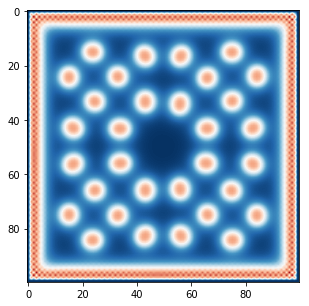

In [24]:
fig = plt.figure()
fig.set_size_inches(5,5)
im = plt.imshow(u, cmap=plt.cm.RdBu, interpolation='bilinear', animated=True)

In the following, I also create an animation showing how the board evolves to produce the patterns shown above.

In [25]:
u0, v0 = 1.0, 0.0
gray_scott_rd.initialize(u0, v0)
r = 10
gray_scott_rd.u[N//2-r:r-N//2, N//2-r:r-N//2] = 0.50
gray_scott_rd.v[N//2-r:r-N//2, N//2-r:r-N//2] = 0.25

fig = plt.figure()
fig.set_size_inches(5,5)
im = plt.imshow(gray_scott_rd.u, cmap=plt.cm.RdBu, interpolation='bilinear', animated=True)
#plt.text(10, 10, r"$Dv/Du={:.2f}, \quad f={:.2f}, \quad k={:.2f}$".format(Dv/Du, parameters["f"], parameters["k"]), 
#         bbox=dict(facecolor='white', alpha=1.0), fontsize=10)
plt.xticks([]); plt.yticks([]);

def updatefig(*args):
    gray_scott_rd.update(dx, dt)
    im.set_array(gray_scott_rd.u)
    return im,

anim = animation.FuncAnimation(fig, updatefig, frames=6000, interval=1.0, blit=False)
rc('animation', html='html5')
plt.close()
anim

## Pattern Formation in the Gray-Scott Reaction-Diffusion System

The Brusselator system is another example capable of producing Turing patterns in the reaction-diffusion scheme. This system is defined by:

$$
\begin{eqnarray}
\frac{\partial u}{\partial t} & = & D_u \vec{\nabla} u + A + u^2v - u(B + 1), \\
\frac{\partial v}{\partial t} & = & D_v \vec{\nabla} u + Bu - u^2v,
\end{eqnarray}
$$.


In [26]:
# Brusselator Reaction System:
def brusselator(u, v, A, B):
    return np.array([A + u**2 * v - (B + 1) * u, 
                     B * u - u**2 * v])

In [27]:
A, B, Du, Dv = 4.5, 8.72, 1.0, 8.0
N = 100
L = 40.0
T = 100.0

dx = L/(N-1)
dt = .9 * dx**2 / (4*max(Du,Dv))
niter = int(T/dt)
print("number of iterations = {}".format(niter))
parameters = {"A":A, "B":B}

number of iterations = 21780


Let's initialize the species to (u0=A,v0=B/A) with an addition of small random perturbation on the grid.

In [28]:
u0, v0 = A, B/A 
brusselator_rd = Reaction_Diffusion(brusselator, parameters, Du=Du, Dv=Dv, N=N, bc="periodic")
brusselator_rd.initialize(u0, v0)

In [29]:
u, v = brusselator_rd.iterate(dx, dt, niter)

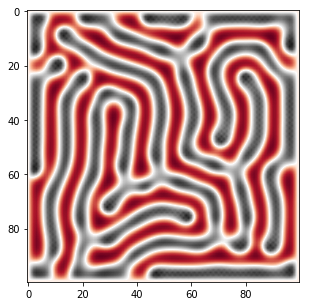

In [30]:
fig = plt.figure()
fig.set_size_inches(5,5)
im = plt.imshow(u, cmap=plt.cm.RdGy, interpolation='bilinear', animated=True)

Again, let's animate the same system to observe the emergence and evolution of the pattern: 

In [31]:
brusselator_rd.initialize(u0, v0)

fig = plt.figure()
fig.set_size_inches(5,5)
im = plt.imshow(brusselator_rd.u, cmap=plt.cm.RdGy, interpolation='bilinear', animated=True)
plt.text(10, 10, r"$Dv/Du={:.2f}, \quad A={:.2f}, \quad B={:.2f}$".format(Dv/Du, parameters["A"], parameters["B"]), 
         bbox=dict(facecolor='white', alpha=1.0), fontsize=10)
#plt.xticks([]); plt.yticks([]);

def updatefig(*args):
    brusselator_rd.update(dx, dt)
    im.set_array(brusselator_rd.u)
    return im,

anim = animation.FuncAnimation(fig, updatefig, frames=10000, interval=1.0, blit=False)
rc('animation', html='html5')
plt.close()
anim

## Notes:

* Should you encounter difficulty in running the embedded animation, try to launch Jupter Notebook using the command:<br>
`jupyter notebook --NotebookApp.iopub_data_rate_limit=10000000000`

* gif files of the simulations can be created in several ways. For example, animations can be saved first (as .mp4 files) and then be converted to gif files later in a terminal, as in the example: <br>
ffmpeg -ss 00:00:00 -i download.mp4 -to 00:00:03 -r 7 -vf scale=-1:1024 brusselator_hopf.gif

## References:

* Murray, J.D., *Mathematical Biology*, Springer-Verlag, New York, 1993.
* Maini, P.K., *Using mathematical models to help understand biological pattern formation*, C. R. Biologies 327, 225–234, 2004
* Pearson, J.E., *Complex Patterns in a Simple System*, Science, Volume 261, 9 Jul 1993. 
* Lee, K.J. *et.al*, *Pattern Formation by Interacting Chemical Fronts*, Science, Volume 261, 9 Jul 1993.
